# Question 1:

Load the data and rearrange it as a pandas DataFrame with the following structure:

- One column per stock and concept: Open, High, Low, Close, Adj close per stock.
- Date as index (properly parsed).
- Rows sorted by date, ascending.
- Be ready for dealing with errors in the names and some missing values.

Paste here the `.dtypes` of the resulting DataFrame.

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_theme(style="whitegrid")

In [3]:
df = pd.read_csv('stocks_unclean.csv', parse_dates=['date'], dayfirst=True, index_col=['date']).sort_index(ascending=True)
df.head()

,variable,value
date,,
2019-12-31,high_GOOG,1.338000e+03
2019-12-31,high_AAPL,7.342000e+01
2019-12-31,open_MSFT,1.567700e+02
2019-12-31,volume_MSFT,1.836940e+07
2019-12-31,close_AMZN,1.847840e+03


In [4]:
df[['variable', 'stock']] = df['variable'].str.split('_', expand=True)

In [5]:
df.head()

,variable,value,stock
date,,,
2019-12-31,high,1.338000e+03,GOOG
2019-12-31,high,7.342000e+01,AAPL
2019-12-31,open,1.567700e+02,MSFT
2019-12-31,volume,1.836940e+07,MSFT
2019-12-31,close,1.847840e+03,AMZN


In [6]:
df['stock'] = df['stock'].replace('AMZ', 'AMZN').replace('GOG', 'GOOG').replace('MST', 'MSFT').replace('APL', 'AAPL')

In [7]:
df.isnull().sum()

variable    29
value       78
stock       29
dtype: int64

---

I am going to deal with the nulls of the rows that do not have variable's names nor stock's names with a Random Forest model.

In [8]:
# The values that does not have variable nor stock name
nulls = df[df['stock'].isnull()]
nulls

,variable,value,stock
date,,,
2020-02-12,NaN,8.180000e+01,NaN
2020-03-27,NaN,2.042168e+08,NaN
2020-05-05,NaN,1.477512e+08,NaN
2020-05-12,NaN,-9.888995e-09,NaN
2020-05-18,NaN,1.351784e+08,NaN
2020-05-26,NaN,8.106000e+01,NaN
2020-05-29,NaN,1.535324e+08,NaN
2020-06-03,NaN,8.128000e+01,NaN
2020-06-18,NaN,9.682040e+07,NaN


In [9]:
def score_rf(X,y,rf):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)
    rf.fit(X_train, y_train)
    scores = np.mean(np.array(rf.predict(X_test)) ==  y_test, axis=0)
    variable_score = scores[1]
    stock_score = scores[0]
    return(variable_score, stock_score)

In [10]:
X = np.atleast_2d(df.dropna()['value']).T
y = np.array(df.dropna()[['stock','variable']])
rf = RandomForestClassifier()
seeds = range(20)
result_variable = np.array([])
result_stock = np.array([])
for seed in seeds:
    variable_score, stock_score = score_rf(X,y,rf)
    result_variable = np.append(result_variable, variable_score)
    result_stock = np.append(result_stock, stock_score)

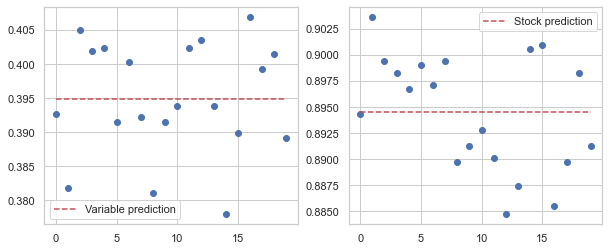

In [11]:
# Visualization of the performance of the prediction
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[10,4])

axes[0].scatter(range(len(result_variable)), result_variable)
axes[0].plot([result_variable.mean()]*len(result_variable), linestyle='dashed', color='r', label='Variable prediction')
axes[0].legend()

axes[1].scatter(range(len(result_stock)), result_stock)
axes[1].plot([result_stock.mean()]*len(result_stock), linestyle='dashed', color='r', label='Stock prediction')
axes[1].legend()

In [12]:
# Chosing variable's names randomly
1 / 5 # number of categories

0.2

The model is very good predicting the Stock's names, but no so good with the Variable's names (but still better than random).

---

In [13]:
# Using the trained Random Forest to predict our missing values.
null_pred = rf.predict(np.atleast_2d(nulls['value']).T)
null_result = pd.DataFrame(null_pred, columns=['stock', 'variable']).set_index(nulls.index)
null_result

,stock,variable
date,,
2020-02-12,AAPL,high
2020-03-27,AAPL,volume
2020-05-05,AAPL,volume
2020-05-12,AAPL,low
2020-05-18,AAPL,volume
2020-05-26,AAPL,close
2020-05-29,AAPL,volume
2020-06-03,AAPL,close
2020-06-18,AAPL,volume


The model estimates that all the missing values belongs to AAPL, which may make sense.

In [14]:
# Updating the values of the original DataFrame and checking that we no longer have null values in those rows.
pd.options.mode.chained_assignment = None 
df.loc[df['stock'].isnull(), ['stock', 'variable']] = null_result[['stock', 'variable']]

In [15]:
df.isnull().sum()

variable     0
value       78
stock        0
dtype: int64

---

In [16]:
stocks = df['stock'].unique()

In [17]:
df = df.pivot_table(values='value', columns=['stock', 'variable'], index='date')

In [18]:
df.head()

stock            AAPL                                                \
variable        close       high        low       open       volume   
date                                                                  
2019-12-31  73.412498  73.419998  72.379997  72.482498  100805600.0   
2020-01-02  75.087502  75.150002  73.797501  74.059998  135480400.0   
2020-01-03  74.357498  75.144997  74.125000  74.287498  146322800.0   
2020-01-06  74.949997  74.989998  73.187500  73.447502  118387200.0   
2020-01-07  74.597504  75.224998  74.370003  74.959999  108872000.0   

stock              AMZN                                               \
variable          close         high          low    open     volume   
date                                                                   
2019-12-31  1847.839966  1853.260010  1832.229980  1842.0  2506500.0   
2020-01-02  1898.010010  1898.010010  1864.150024  1875.0  4029000.0   
2020-01-03  1874.969971  1886.199951  1864.500000  1864.5  3764400.0   
2020-01-06  1902.880005  1903.689941  1860.000000  1860.0  4061800.0   
2020-01-07  1906.859985  1913.890015  1892.040039  1904.5  4044900.0   

stock              GOOG                                                    \
variable          close         high          low         open     volume   
date                                                                        
2019-12-31  1337.020020  1338.000000  1329.084961  1330.109985   961800.0   
2020-01-02  1367.369995  1368.140015  1341.550049  1341.550049  1406600.0   
2020-01-03  1360.660034  1372.500000  1345.543945  1347.859985  1186400.0   
2020-01-06  1394.209961  1396.500000          NaN  1350.000000  1732300.0   
2020-01-07  1393.339966  1402.989990  1390.380005  1397.939941  1502700.0   

stock             MSFT                                                  
variable         close        high         low        open      volume  
date                                                                    
2019-12-31  157.699997  157.770004  156.449997  156.770004  18369400.0  
2020-01-02  160.619995  160.729996  158.330002  158.779999  22622100.0  
2020-01-03  158.619995  159.949997         NaN  158.320007  21116200.0  
2020-01-06  159.029999  159.100006  156.509995  157.080002  20813700.0  
2020-01-07  157.580002  159.669998  157.320007  159.320007  21634100.0

In [19]:
df.dtypes

stock  variable
AAPL   close       float64
       high        float64
       low         float64
       open        float64
       volume      float64
AMZN   close       float64
       high        float64
       low         float64
       open        float64
       volume      float64
GOOG   close       float64
       high        float64
       low         float64
       open        float64
       volume      float64
MSFT   close       float64
       high        float64
       low         float64
       open        float64
       volume      float64
dtype: object

In [20]:
pd.options.mode.chained_assignment = None 

In [21]:
for stock in stocks:
    df[stock]['close'].fillna(df[stock]['open'].shift(1), inplace=True)
    df[stock]['open'].fillna(df[stock]['close'].shift(-1), inplace=True)
    df[stock]['volume'].interpolate(method='pad',inplace=True)
    df[stock]['high'].fillna(df[stock][['open', 'close']].max(axis=1),inplace=True)
    df[stock]['low'].fillna(df[stock][['open', 'close']].min(axis=1), inplace=True)

In [22]:
df.isnull().sum()

stock  variable
AAPL   close       0
       high        0
       low         0
       open        0
       volume      0
AMZN   close       0
       high        0
       low         0
       open        0
       volume      0
GOOG   close       0
       high        0
       low         0
       open        0
       volume      0
MSFT   close       0
       high        0
       low         0
       open        0
       volume      0
dtype: int64

# Question 2 
Visualize the data as follows:

## Create a 2x2 grid of plots in which you plot the "Open" in green and "Close" in red for each stock (0.5 points).

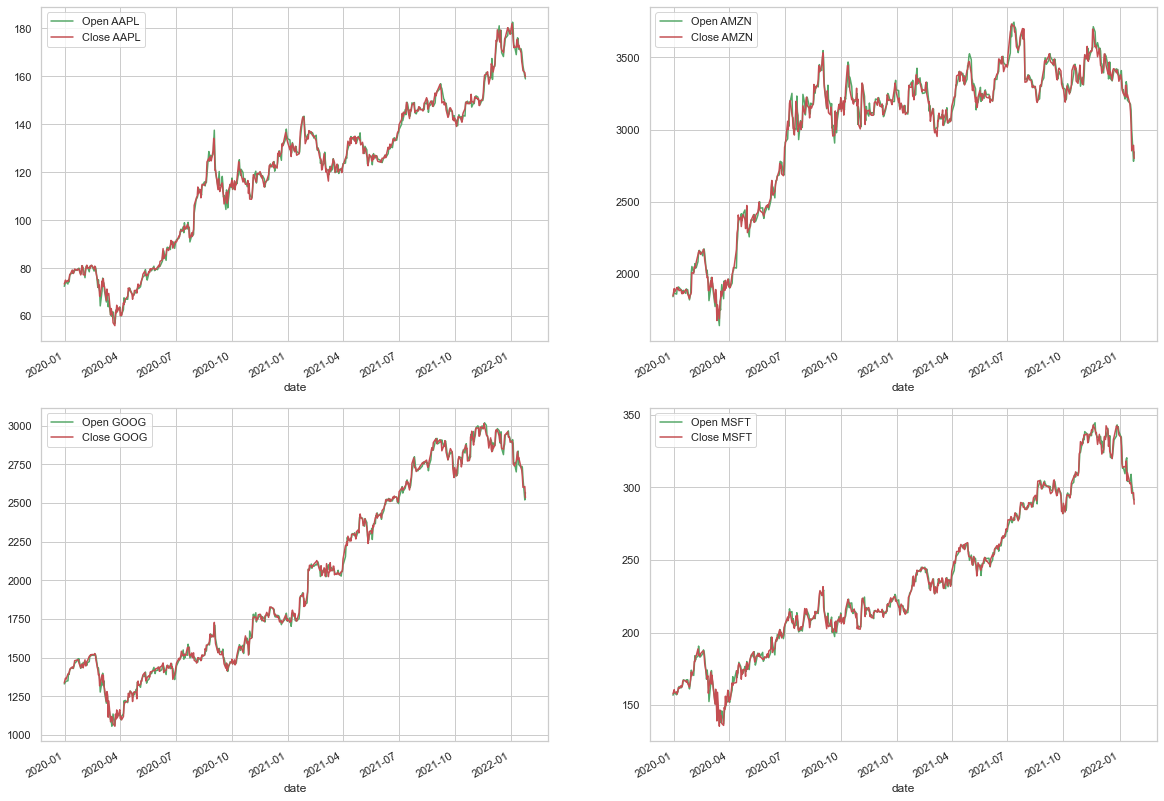

In [23]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

df['AAPL']['open'].plot(ax=axes[0,0], label='Open AAPL', color='g')
df['AAPL']['close'].plot(ax=axes[0,0], label='Close AAPL', color='r')

axes[0,0].legend()

df['AMZN']['open'].plot(ax=axes[0,1], label='Open AMZN', color='g')
df['AMZN']['close'].plot(ax=axes[0,1], label='Close AMZN', color='r')

axes[0,1].legend()

df['GOOG']['open'].plot(ax=axes[1,0], label='Open GOOG', color='g')
df['GOOG']['close'].plot(ax=axes[1,0], label='Close GOOG', color='r')

axes[1,0].legend()

df['MSFT']['open'].plot(ax=axes[1,1], label='Open MSFT', color='g')
df['MSFT']['close'].plot(ax=axes[1,1], label='Close MSFT', color='r')

axes[1,1].legend()

## Repeat the 2x2 grid but resampling with the weekly average of "Open" and "Close" (0.5 points)

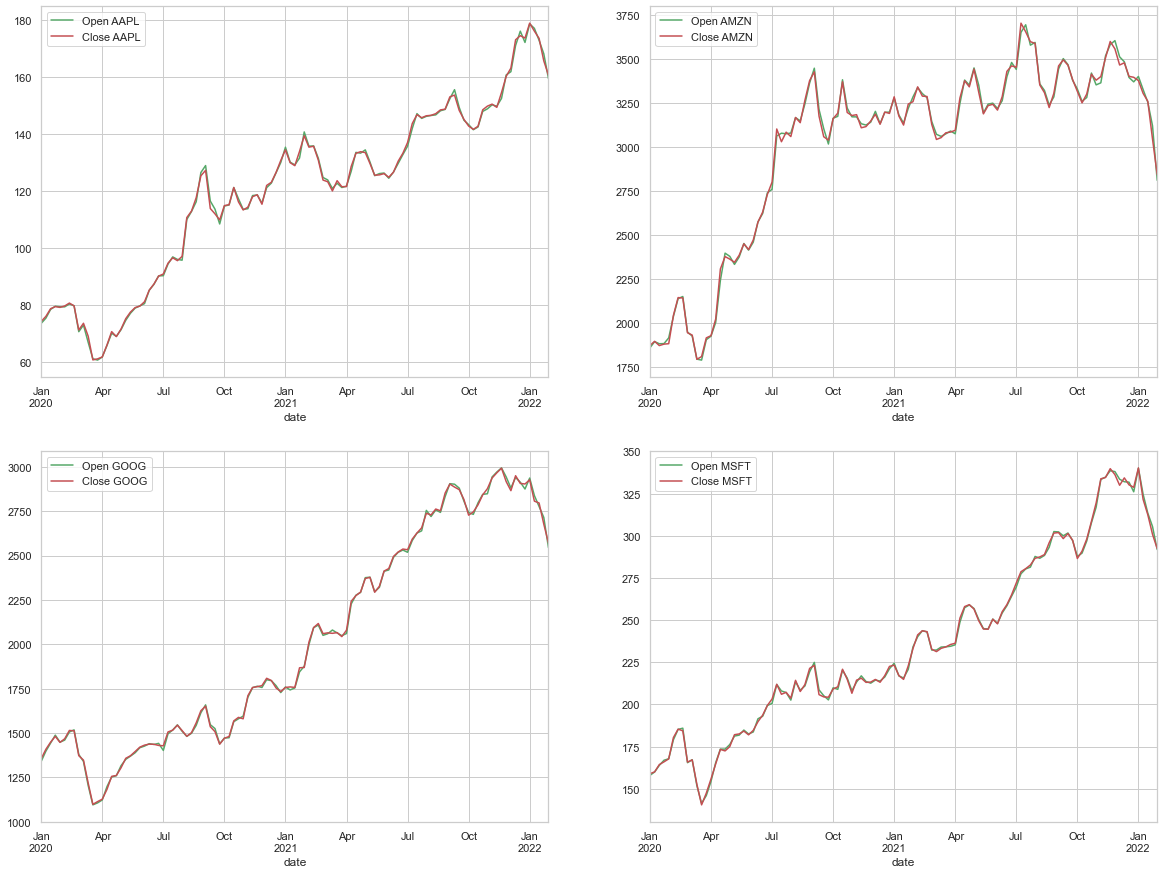

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

df['AAPL']['open'].resample('W').mean().plot(ax=axes[0,0], label='Open AAPL', color='g')
df['AAPL']['close'].resample('W').mean().plot(ax=axes[0,0], label='Close AAPL', color='r')

axes[0,0].legend()

df['AMZN']['open'].resample('W').mean().plot(ax=axes[0,1], label='Open AMZN', color='g')
df['AMZN']['close'].resample('W').mean().plot(ax=axes[0,1], label='Close AMZN', color='r')

axes[0,1].legend()

df['GOOG']['open'].resample('W').mean().plot(ax=axes[1,0], label='Open GOOG', color='g')
df['GOOG']['close'].resample('W').mean().plot(ax=axes[1,0], label='Close GOOG', color='r')

axes[1,0].legend()

df['MSFT']['open'].resample('W').mean().plot(ax=axes[1,1], label='Open MSFT', color='g')
df['MSFT']['close'].resample('W').mean().plot(ax=axes[1,1], label='Close MSFT', color='r')

axes[1,1].legend()

## Add meaningful visualizations of your choice (0.5 points)

In [25]:
log_AAPL = np.log(df['AAPL']['close']).diff()
log_AMZN = np.log(df['AMZN']['close']).diff()
log_GOOG = np.log(df['GOOG']['close']).diff()
log_MSFT = np.log(df['MSFT']['close']).diff()

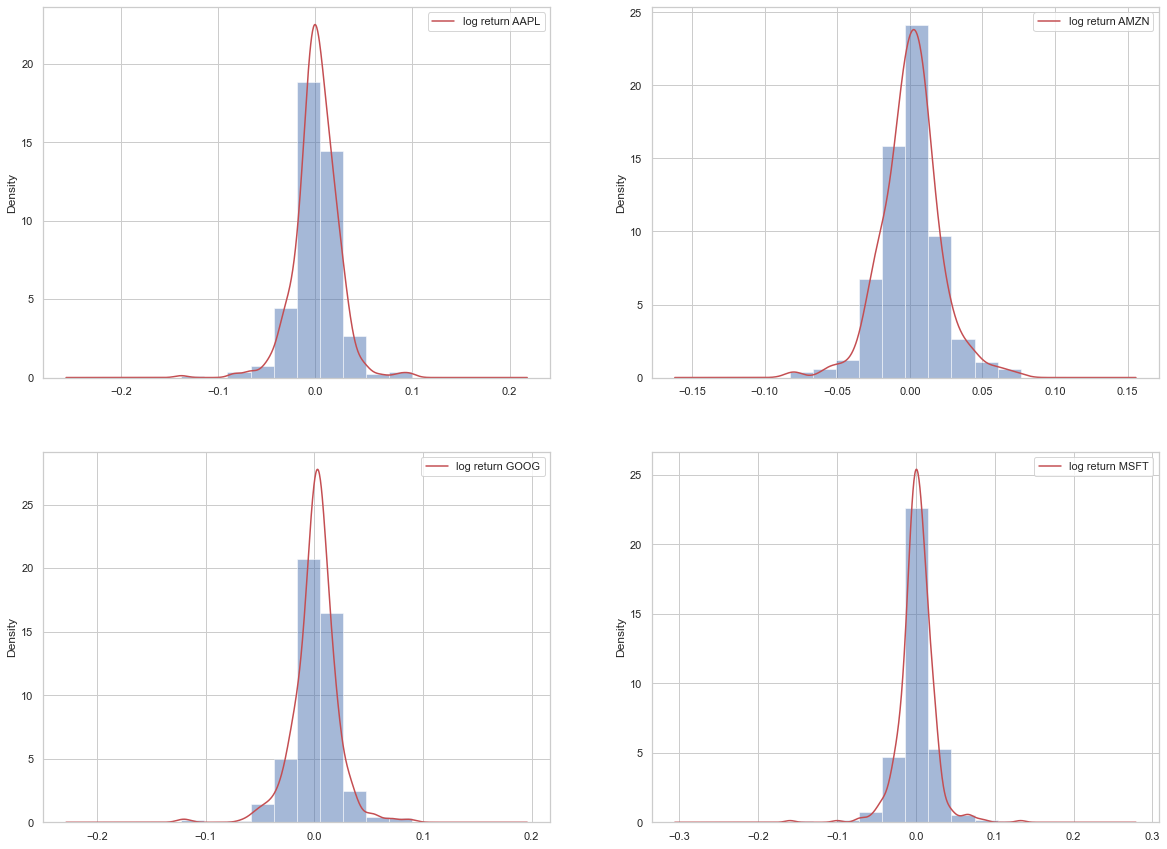

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 15))

log_AAPL.plot.kde(ax=axes[0,0], label='log return AAPL', color='r')
log_AAPL.hist(ax=axes[0,0], density=True, alpha=0.5)

axes[0,0].legend()

log_AMZN.plot.kde(ax=axes[0,1], label='log return AMZN', color='r')
log_AMZN.hist(ax=axes[0,1], density=True, alpha=0.5)

axes[0,1].legend()

log_GOOG.plot.kde(ax=axes[1,0], label='log return GOOG', color='r')
log_GOOG.hist(ax=axes[1,0], density=True, alpha=0.5)

axes[1,0].legend()

log_MSFT.plot.kde(ax=axes[1,1], label='log return MSFT', color='r')
log_MSFT.hist(ax=axes[1,1], density=True, alpha=0.5)

axes[1,1].legend()

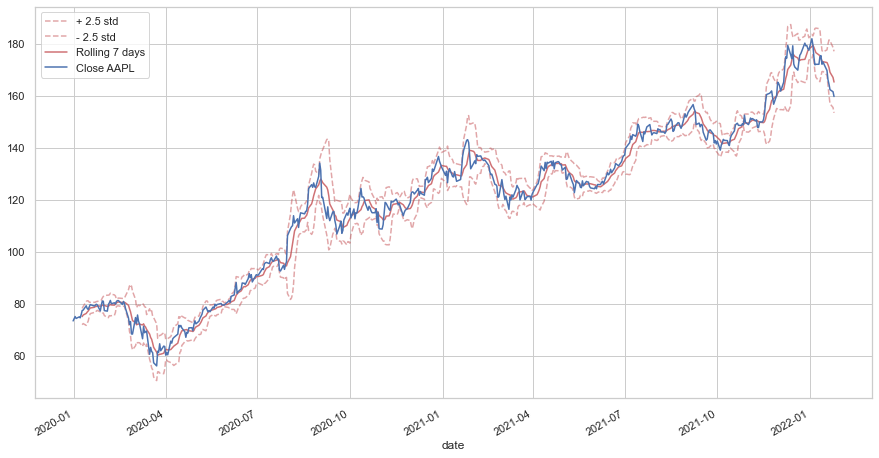

In [27]:
# A very commun graph in trading. The price with a rolling mean and 2.5 standards deviation above and below (rolling 7 days).

upper_bound = (df['AAPL']['close'].rolling(7).mean()+2.5*df['AAPL']['close'].rolling(7).std())
lower_bound = (df['AAPL']['close'].rolling(7).mean()-2.5*df['AAPL']['close'].rolling(7).std())

rolling_7 = df['AAPL']['close'].rolling(7).mean()
upper_bound.plot(label='+ 2.5 std',color='r',linestyle='--',alpha=0.5)
lower_bound.plot(label='- 2.5 std',color='r',linestyle='--',alpha=0.5)
rolling_7.plot(label='Rolling 7 days',color='r',alpha=0.8)
df['AAPL']['close'].plot(label='Close AAPL', color='b',figsize= (15,8)).legend()

# Question 3:
Create a function that calculates the Return of Investment (ROI).

Let's suppose you buy one stock one day, you hold it for N days (lookback period) and after N days you sell it. The ROI formula is:

$$ \frac{FVI - IVI}{IVI}*100 $$

Now that we know how to calculate the ROI, create a function in Python that receives as parameters the following:

lookback: the number of days you hold the stock.

name: the name of the stock, using the "Close" value of the stock.

data: the dataframe with the stock data.

Paste here the result of `roi(365, "GOOG", df)`.

In [28]:
def roi(lookback, name, data):
    return(100 * (data[name]['close'] / data[name]['close'].shift(lookback) - 1))

In [29]:
roi(365, "GOOG", df)

date
2019-12-31          NaN
2020-01-02          NaN
2020-01-03          NaN
2020-01-06          NaN
2020-01-07          NaN
                ...    
2022-01-19    81.536180
2022-01-20    78.472691
2022-01-21    75.762010
2022-01-24    73.065534
2022-01-25    66.927462
Name: close, Length: 522, dtype: float64

# Question 4:
1.5 Points.

Apply the ROI function to the portfolio. Create as many ROI columns as different stocks you have in the portfolio and plot them, representing for each stock:

- ROI after holding the stock for 365 days (red, dashed line) (0.5 points).

- ROI after holding the stock for 180 days (blue, dotted line) (0.5 points).

- ROI after holding the stock for 90 days (green, solid line) (0.5 points).

In [30]:
# Creating the columns with the different ROI's
roi_years = [365, 180, 90]
for stock in stocks:
    for period in roi_years:
        df[f'{stock} ROI {period}'] = roi(period, stock, df)

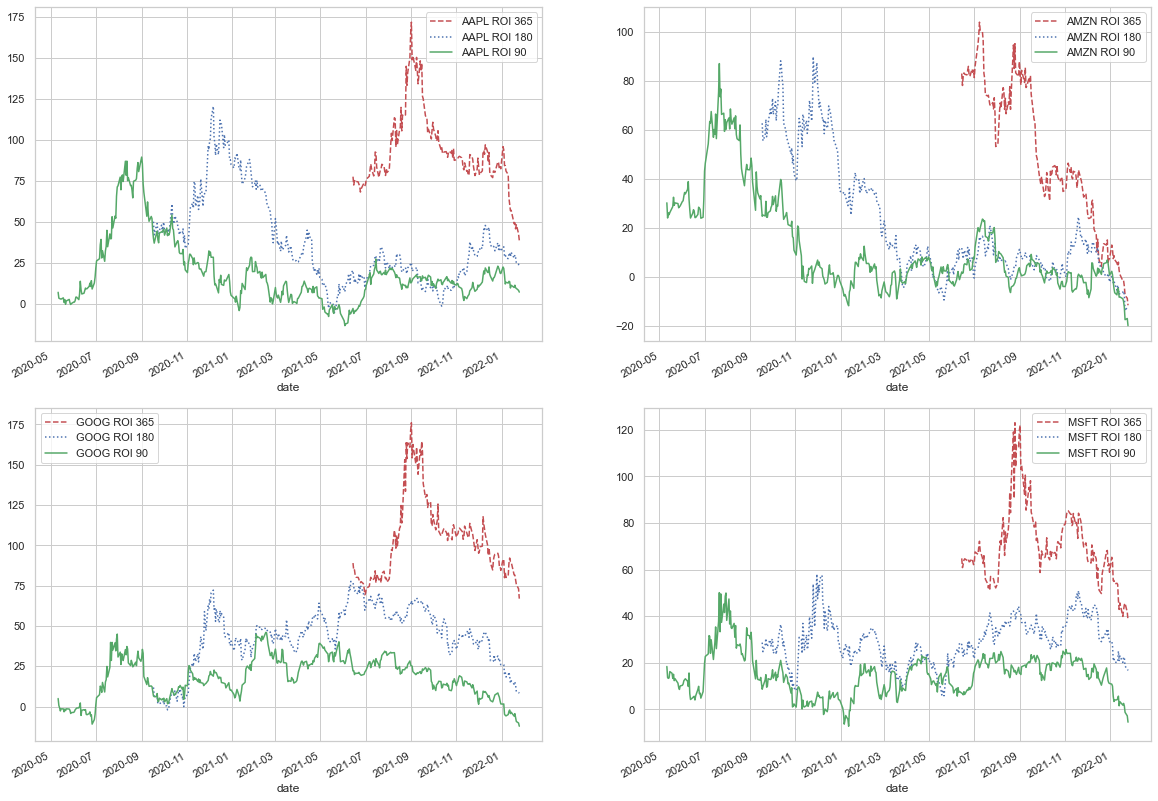

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20,15))

df['AAPL ROI 365'].plot(ax=axes[0,0], label='AAPL ROI 365', color='r', linestyle='--')
df['AAPL ROI 180'].plot(ax=axes[0,0], label='AAPL ROI 180', color='b', linestyle=':')
df['AAPL ROI 90'].plot(ax=axes[0,0], label='AAPL ROI 90', color='g', linestyle='-')

axes[0,0].legend()

df['AMZN ROI 365'].plot(ax=axes[0,1], label='AMZN ROI 365', color='r', linestyle='--')
df['AMZN ROI 180'].plot(ax=axes[0,1], label='AMZN ROI 180', color='b', linestyle=':')
df['AMZN ROI 90'].plot(ax=axes[0,1], label='AMZN ROI 90', color='g', linestyle='-')

axes[0,1].legend()

df['GOOG ROI 365'].plot(ax=axes[1,0], label='GOOG ROI 365', color='r', linestyle='--')
df['GOOG ROI 180'].plot(ax=axes[1,0], label='GOOG ROI 180', color='b', linestyle=':')
df['GOOG ROI 90'].plot(ax=axes[1,0], label='GOOG ROI 90', color='g', linestyle='-')

axes[1,0].legend()

df['MSFT ROI 365'].plot(ax=axes[1,1], label='MSFT ROI 365', color='r', linestyle='--')
df['MSFT ROI 180'].plot(ax=axes[1,1], label='MSFT ROI 180', color='b', linestyle=':')
df['MSFT ROI 90'].plot(ax=axes[1,1], label='MSFT ROI 90', color='g', linestyle='-')

axes[1,1].legend()

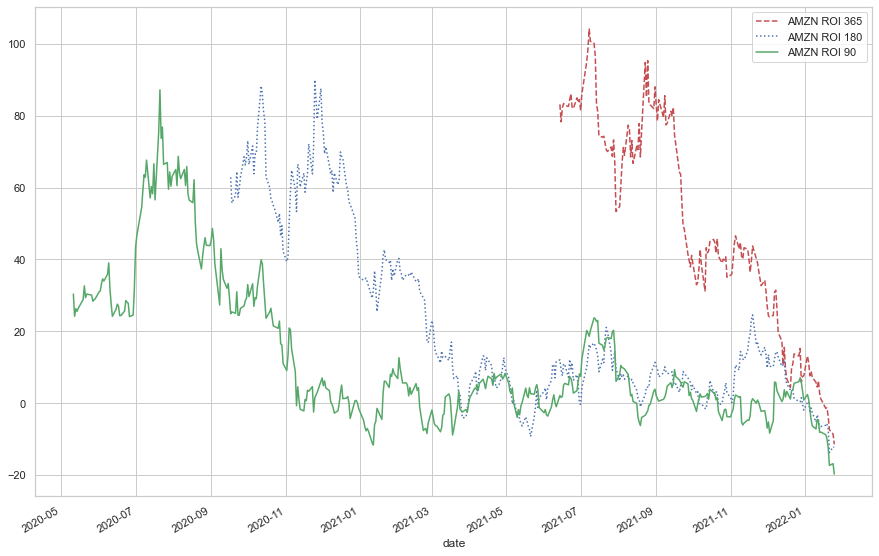

In [32]:
df['AMZN ROI 365'].plot(label='AMZN ROI 365', color='r', linestyle='--')
df['AMZN ROI 180'].plot(label='AMZN ROI 180', color='b', linestyle=':')
df['AMZN ROI 90'].plot(label='AMZN ROI 90', color='g', linestyle='-', figsize=(15,10))
plt.legend()

# Question 5
The average ROI is a single number that comes from computing the overall mean of the ROI over the whole period of the series. Given these two portfolios, which one has the best average ROI, with a lookback of 365 days? (Keep in mind that ROI is a percentage and you can't average it directly - you need to convert the ROI to a return in currency by multiplying it by the buy price, and then average that over the period)



   - Portfolio 1:

       AAPL 40%

       GOOG 30%

       MSFT 20%

       AMZN 10%



   - Portfolio 2:

       AAPL 30%

       GOOG 20%

       MSFT 10%

       AMZN 40%

In [33]:
mean_roi = np.array(
[(df['AAPL ROI 365']/100*df['AAPL']['close'].shift(365)).mean(),
(df['AMZN ROI 365']/100*df['AMZN']['close'].shift(365)).mean(),
(df['GOOG ROI 365']/100*df['GOOG']['close'].shift(365)).mean(),
(df['MSFT ROI 365']/100*df['MSFT']['close'].shift(365)).mean()])

In [34]:
port1 = np.array(
[0.4, 0.1, 0.3, 0.2])

In [35]:
Portfolio_1 = mean_roi @ port1
Portfolio_1

581.820732592929

In [36]:
port2 = np.array(
[0.3, 0.4, 0.2, 0.1])

In [37]:
Portfolio_2 = mean_roi @ port2
Portfolio_2

738.2667359661905

# Question 6
Find a better combination in your portfolio. The new combination should beat the best portfolio that you found in the previous exercise.

In [38]:
mean_roi

array([  72.41156871, 1056.34873233, 1407.86312963,  124.31146493])

In [39]:
np.max(mean_roi)

1407.8631296340068

Naturally, a portfolio built with only the stock with best performance its going to be the best in terms of average result.

But, lets build a more "diversified" combination with at least 30% more in average than the best in the previous exercise.

In [40]:
for seed in reversed(range(500_000)):
    rng = np.random.default_rng(seed)
    opt_port = np.array([rng.random(), rng.random(), rng.random(), rng.random()])
    if ((mean_roi @ opt_port) > (mean_roi @ port2)*(1.3)) & (abs(sum(opt_port)-1) < 0.0001):
        break
opt_port, sum(opt_port), mean_roi @ opt_port, seed

(array([0.04278063, 0.18963731, 0.61645564, 0.15120298]),
 1.0000765666678495,
 1090.102379815283,
 454503)

In [41]:
better_portfolio = pd.DataFrame(np.round((opt_port*100),2), stocks, columns=['weight %'])
better_portfolio

,weight %
GOOG,4.28
AAPL,18.96
MSFT,61.65
AMZN,15.12


In [42]:
Better_portfolio = mean_roi @ opt_port
Better_portfolio

1090.102379815283